In [2]:
import os, time
import matplotlib.pyplot as plt
import itertools
import pickle
import imageio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from model import Net
import argparse
import utils
from collections import OrderedDict

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
"""# **Generator and Discriminator and other definitions**"""

# G(z)
class generator(nn.Module):
    # initializers
    def __init__(self, d=128):
        super(generator, self).__init__()
        #self.deconv1 = nn.ConvTranspose2d(100, d*8, 4, 1, 0)
        self.deconv1 = nn.ConvTranspose2d(100, d*8, 7, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*8)
        self.deconv2 = nn.ConvTranspose2d(d*8, d*4, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*4)
        self.deconv3 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d*2)
        self.deconv4 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(d)
        self.deconv5 = nn.ConvTranspose2d(d, 1, 4, 2, 1)
        self.avgpool = nn.AvgPool2d(4)

    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

    # forward method
    def forward(self, input):
        # x = F.relu(self.deconv1(input))
        x = F.relu(self.deconv1_bn(self.deconv1(input)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        #print("x 3: {}".format(x.shape))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        #print("x 4: {}".format(x.shape))
        x = self.deconv5(x)
        x = F.tanh(self.avgpool(x))
        #print("x 5: {}".format(x.shape))

        return x

In [5]:
def load_model(model_type, dict_file):
    state_dict = torch.load(dict_file, map_location=lambda storage, loc: storage)

    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k
        if k[:7] == 'module.':
            name = k[7:] # remove `module.`
        if name[:2] == 'fc':
            name = 'decoder.' + name
        new_state_dict[name] = v

    model = None
    if model_type == 'g':
        model = generator(128)
    elif model_type == 'd':
        model = Net(num_conv_in_channel=args.num_conv_in_channel,
                    num_conv_out_channel=args.num_conv_out_channel,
                    num_primary_unit=args.num_primary_unit,
                    primary_unit_size=args.primary_unit_size,
                    num_classes=args.num_classes,
                    output_unit_size=args.output_unit_size,
                    num_routing=args.num_routing,
                    use_reconstruction_loss=args.use_reconstruction_loss,
                    regularization_scale=args.regularization_scale,
                    input_width=args.input_width,
                    input_height=args.input_height,
                    cuda_enabled=args.cuda)
    elif model_type == 'b_g':
        model = base_generator(128)
    elif model_type == 'b_d':
        model = base_discriminator(128)

    model.load_state_dict(new_state_dict)
    return model

In [6]:
G = load_model('g', 'MNIST_CAPSGAN_FC_results/generator_param.pkl')

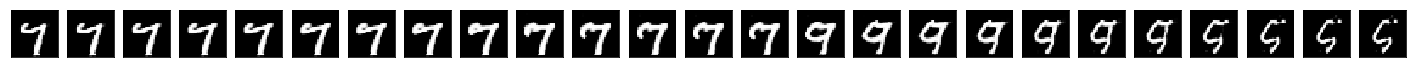

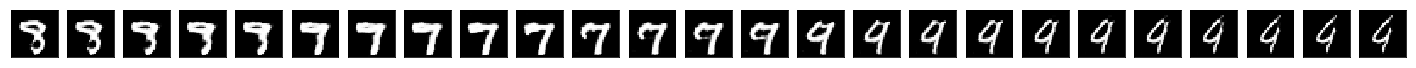

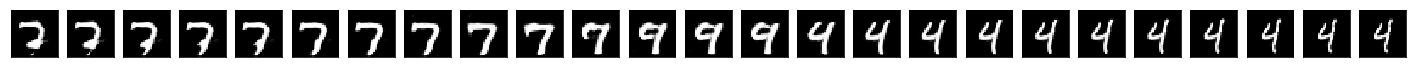

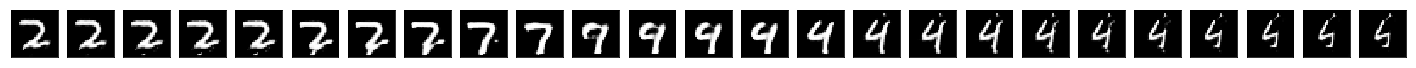

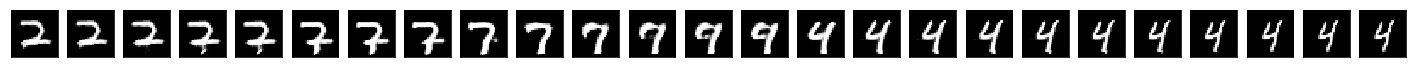

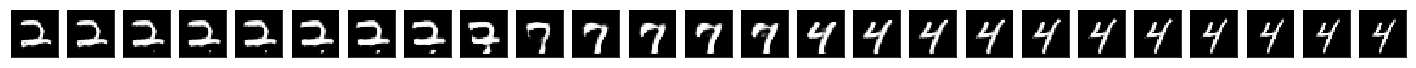

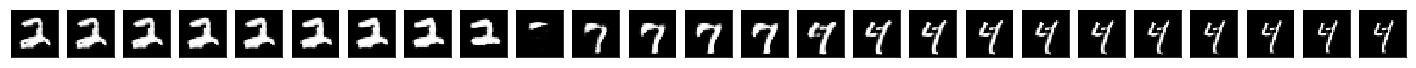

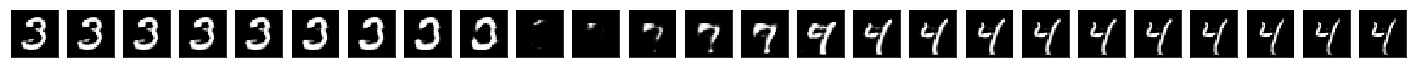

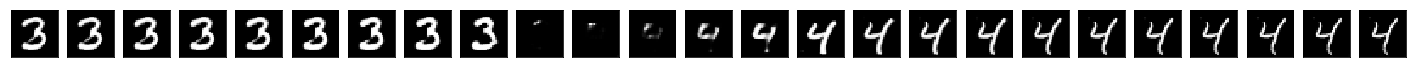

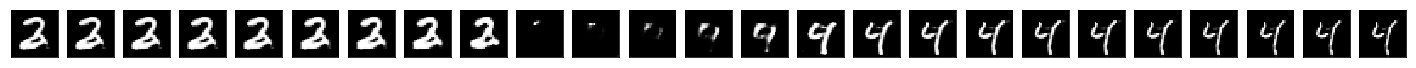

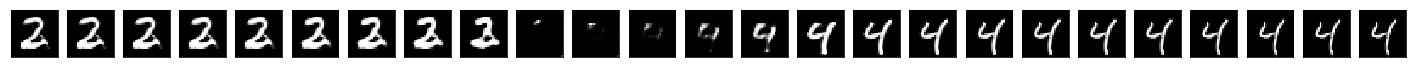

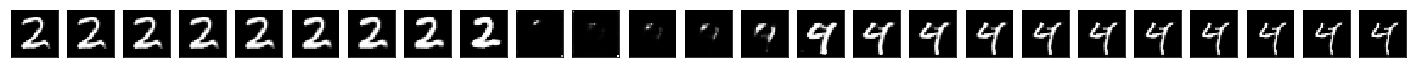

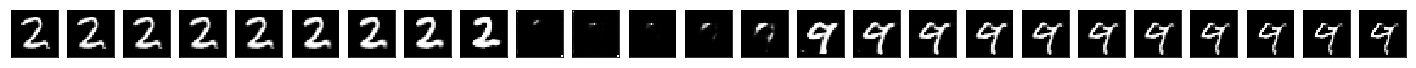

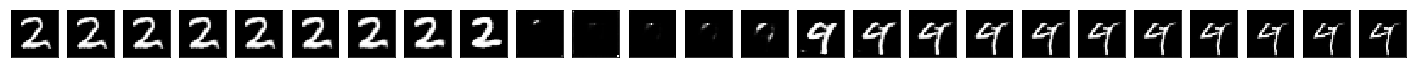

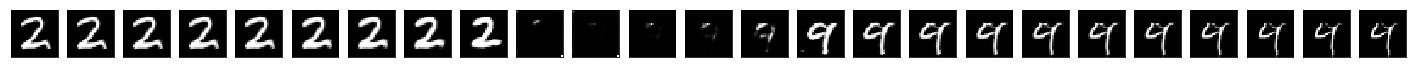

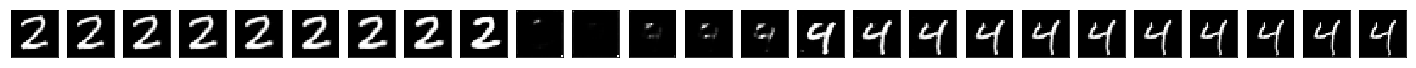

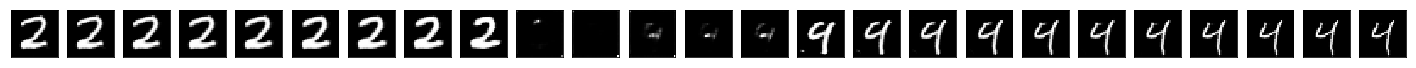

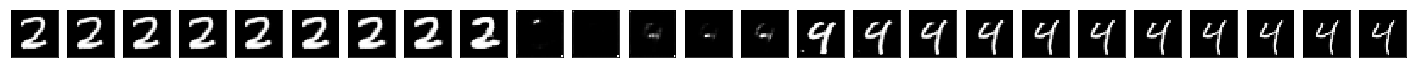

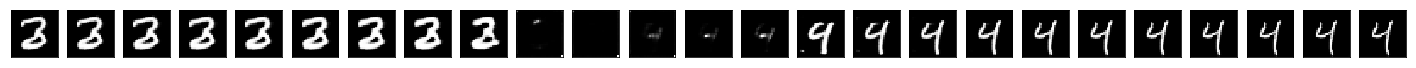

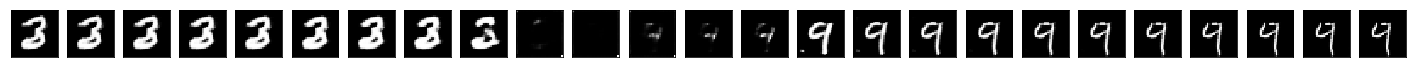

In [7]:
# Generate our one Z vector
batch = 25
zs = Variable(torch.randn((1, 100)).view(-1, 100, 1, 1))
# Repeat it batch number of times. For each z in the batch we'll change one dimension
zs = zs.repeat(batch, 1, 1, 1)

# Generate values for the dimension we're modifying 
fixed_dim, _ = torch.sort(torch.randn((batch, 1)), dim=0)
fixed_dim = fixed_dim.unsqueeze(-1) * 10
fixed_dim = fixed_dim.cuda()

for ind in range(20):
    # Set the modified dimension
    zs[:, 5*ind] = fixed_dim
    zs = zs

    # Generate!
    generated = G(zs)

    # Plot!
    size_figure_grid = batch
    fig, ax = plt.subplots(1, size_figure_grid, figsize=(25, 25))

    for i in range(size_figure_grid):
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)

    for k in range(size_figure_grid):
        ax[k].cla()
        ax[k].imshow(generated[k].squeeze().cpu().data.numpy(), cmap='gray')
    imageio.mimsave('MNIST_CAPSGAN_results/2_transformation_'+ str(ind*5) + '.gif', generated.squeeze().cpu().data.numpy(), fps=5)